Import Libraries

In [3]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.stats import poisson
import scipy as sp



### Variables

- **N**: Number of Particles/ensemble members  
- **n_locations**: Number of Locations (for the multi-node purposes)  
- **t_max**: Maximum Time  
- **dt**: Time Difference  
- **N_p**: Population for each location  
- **time_vector**: Time Initialization  
- **observation_index**: Indices of observation times  
- **lambda_max**: Maximum infected for initial condition  
- **beta_min**: Minimum beta  
- **beta_max**: Maximum beta  
- **gamma**: Recovery Rate  
- **tau_day**: Traversing ratio in daytime  
- **tau_night**: Traversing ratio in nighttime  



In [4]:
rng = default_rng(12345)
N = 1000  
n_locations = 2 
t_max = 80
dt = 1
N_p = np.array([100000] * n_locations)  
time_vector = np.arange(0, t_max, dt, dtype=float)
observation_index = np.arange(0, t_max, dt)  
lambda_max = 10 
beta_min = 0.2  
beta_max = 0.5 
gamma = 1.0/3
tau_day = 1 / 3
tau_night = 2 / 3

### Function Descriptions

- **`gen_population(n)`**: Generates a random population size between 5000 and 10000 for each location.  
- **`gen_movement(population)`**: Creates a movement matrix where movement between locations is randomly assigned between 3% and 8% of the destination population, ensuring no self-movement.  
- **`gen_no_movement(population)`**: Generates a zero movement matrix, meaning there is no movement between locations.  
- **`gen_mov_ratio(movement, population)`**: Computes the movement ratio by dividing the movement matrix by the population of each location.  


In [5]:
def gen_population(n):
    return rng.integers(5000, 10000, n)


def gen_movement(population):
    movement = np.zeros((len(population), len(population)))
    for i in range(len(population)):
        for j in range(len(population)):
            movement[i][j] = rng.integers(
                0.03 * population[j], 0.08 * population[j])
    np.fill_diagonal(movement, 0)
    return movement


def gen_no_movement(population):
    movement = np.zeros((len(population), len(population)))
    for i in range(len(population)):
        for j in range(len(population)):
            movement[i][j] = 0
    np.fill_diagonal(movement, 0)
    return movement


def gen_mov_ratio(movement, population):
    return movement/population

In [6]:
movement = gen_movement(N_p)
mov_ratio = gen_mov_ratio(movement, N_p)

### Beta Decay Function

The beta decay function is defined as:

\[
\beta(t) =
\begin{cases} 
\beta_0, & \quad \text{for } 0 \leq t \leq T, \\[10pt]
\beta_{\infty} + (\beta_0 - \beta_{\infty}) e^{-\frac{(t - T)}{\tau}}, & \quad \text{for } t > T.
\end{cases}
\]

where:
- \( \beta_0 \) is the initial transmission rate.
- \( \beta_{\infty} \) is the asymptotic transmission rate.
- \( T \) is the time at which decay starts.
- \( \tau \) is the decay time constant.

This function ensures that the transmission rate remains constant at \( \beta_0 \) until time \( T \) and then exponentially decays toward \( \beta_{\infty} \).


In [7]:
def beta_decay(t, beta_0, beta_infty, T, tau):
    def case_1(t_):
        return beta_0

    def case_2(t_):
        return beta_infty + (beta_0 - beta_infty)*np.exp(-(t_ - T)/tau)

    return np.piecewise(t, [t <= T, t > T], [case_1, case_2])

In [8]:
def gen_initial_cond(population):
    n = len(population)
    I = rng.integers(10, 50, n)  # Smaller initial infections
    S = population - I
    R = np.zeros(n)
    return np.array([S, I, R]).T


### SIR Tau-Leap Model with Movement

The **`SIR_tau_leap(population, mov_ratio, initial_cond, beta, t)`** function simulates the spread of an infectious disease using a **Stochastic SIR Tau-Leap Model** with movement between multiple locations.

- **Inputs:**
  - `population`: Population size for each location.
  - `mov_ratio`: Movement ratio matrix defining transitions between locations.
  - `initial_cond`: Initial S, I, R values for each location.
  - `beta`: Time-dependent transmission rate.
  - `t`: Number of time steps to simulate.

- **Functionality:**
  - Tracks susceptible (S), infected (I), and recovered (R) populations over time.
  - Computes **daytime movement**, where susceptible and infected individuals relocate based on `mov_ratio`.
  - Simulates **infection transmission**, where infection occurs based on contact probability and transmission rate `beta`.
  - Implements **recovery dynamics**, where infected individuals recover at a fixed rate.
  - Updates **nighttime infection and recovery**, adjusting S, I, and R values accordingly.
  - Uses **Poisson-distributed stochastic transitions** for infections and recoveries.

- **Output:** 
  - Returns a `result` array of shape `(n_locations, 3, t)`, representing the S, I, R populations at each location over time.

This function efficiently models epidemic spread in a multi-location system while incorporating movement dynamics.


In [9]:
def SIR_tau_leap(population, mov_ratio, initial_cond, beta, t):
    n = len(population)
    result = np.zeros((n, 3, t))
    result[:, :, 0] = initial_cond
    outflow_ratio = np.diag(np.sum(mov_ratio, axis=0))

    for i in range(1, t):
        mov_S = mov_ratio @ np.diag(result[:, 0, i-1])
        mov_I = mov_ratio @ np.diag(result[:, 1, i-1])
        beta_i = beta[:, i-1]

        movement[range(n), range(n)] = 1
        mov_SI = np.divide(np.multiply(mov_I, mov_S), movement, where=movement != 0)
        mov_SI[range(n), range(n)] = 0
        transfer_SI = rng.poisson(np.clip(np.diag(beta_i) @ mov_SI * tau_day, 0, None))

        S = np.clip(result[:, 0, i-1] - np.sum(mov_S, axis=0).T, 0, None)
        I = np.clip(result[:, 1, i-1] - np.sum(mov_I, axis=0).T, 0, None)
        R = result[:, 2, i-1]

        force_of_infection_day = rng.poisson(np.clip(tau_day * beta_i * S * I / population, 0, None))
        force_of_recovery_day = rng.poisson(np.clip(0.2 * I * tau_day, 0, None))

        result[:, 0, i] = S - force_of_infection_day + np.sum(mov_S, axis=0).T - np.sum(transfer_SI, axis=0).T
        result[:, 1, i] = I + force_of_infection_day - force_of_recovery_day + np.sum(mov_I, axis=0).T + np.sum(transfer_SI, axis=0).T
        result[:, 2, i] = R + force_of_recovery_day

        S = result[:, 0, i]
        I = result[:, 1, i]
        R = result[:, 2, i]

        force_of_infection_night = rng.poisson(np.clip(tau_night * beta_i * S * I / population, 0, None))
        force_of_recovery_night = rng.poisson(np.clip(0.2 * I * tau_night, 0, None))

        result[:, 0, i] = S - force_of_infection_night
        result[:, 1, i] = I + force_of_infection_night - force_of_recovery_night
        result[:, 2, i] = R + force_of_recovery_night

    return result


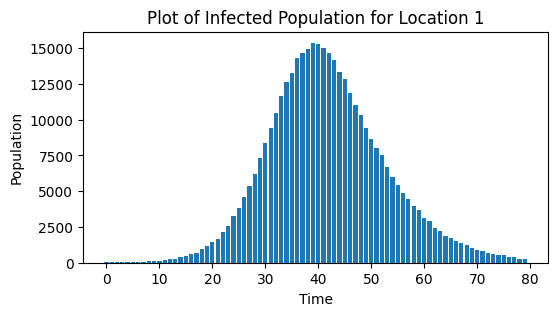

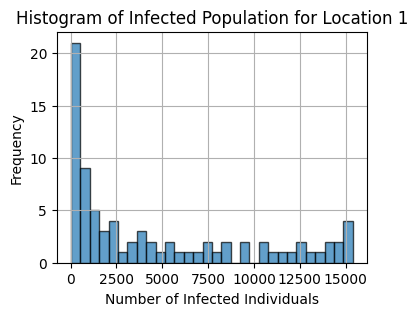

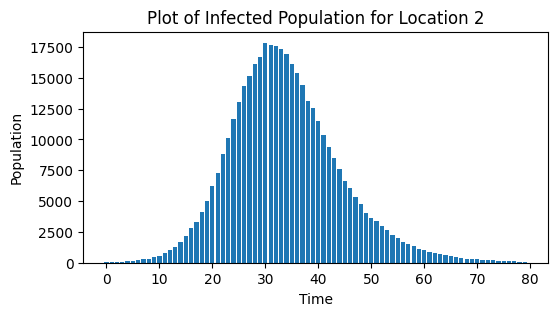

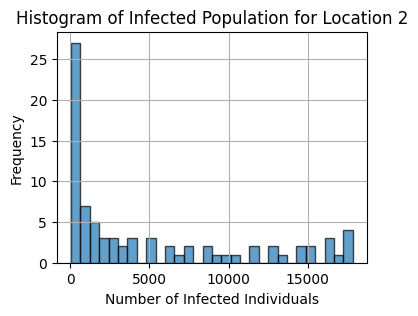

In [10]:
# Define beta over time (decay) for each location
# Generate initial conditions
initial_cond = gen_initial_cond(N_p)
movement = gen_movement(N_p)
movement[movement == 0] = 0.01  # Ensure there's always a small movement
mov_ratio = gen_mov_ratio(movement, N_p)

beta = np.zeros((n_locations, len(time_vector)))
for i in range(n_locations):
    beta[i, :] = beta_decay(time_vector, beta_max, beta_min, 10, 50)

# Run the SIR_tau_leap function to simulate over the time vector
result = SIR_tau_leap(N_p, mov_ratio, initial_cond, beta, len(time_vector))

# Extract the number of infected individuals over time for each location
infected_over_time = result[:, 1, :]  # Shape (n_locations, time)

# Generate observation data: infected population at each observation point
observation_times = np.arange(0, len(time_vector), int(1 / dt))  # Every 1 time unit
# B_vectors = np.random.poisson(infected_over_time[:, observation_times])
B_vectors = rng.normal(loc=infected_over_time[:, observation_times], scale=np.sqrt(infected_over_time[:, observation_times]))
# B_vectors = np.random.poisson(beta*(infected_over_time[:, observation_times]/np.expand_dims(N_p, axis=1))*result[:, 0, observation_times])

for loc in range(n_locations):
    # Get the infected data for the current location at observation times
    observed_infected = B_vectors[loc, :]
    
    plt.figure(figsize=(6, 3))
    plt.bar(time_vector, B_vectors[loc, :])
    plt.title(f'Plot of Infected Population for Location {loc+1}')
    plt.xlabel('Time')
    plt.ylabel('Population')
    # Create a histogram
    plt.figure(figsize=(4, 3))
    plt.hist(observed_infected, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of Infected Population for Location {loc+1}')
    plt.xlabel('Number of Infected Individuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


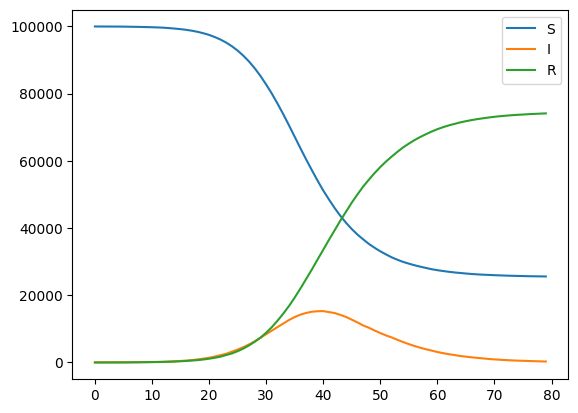

In [11]:
node=0
plt.plot(result[node, 0, :], label='S')
plt.plot(result[node, 1, :], label='I')
plt.plot(result[node, 2, :], label='R')
plt.legend()
plt.show()

## **Particle Filter Algorithm**

### **Step 1: Initialize Particles**
Initialize \( N \) particles from the prior distribution:

$$
x^p_0 \sim p(x_0), \quad p = 1, \dots, N
$$

Assign equal initial weights:

$$
w^p_0 = \frac{1}{N}
$$

---

### **Step 2: Prediction**
Propagate each particle using the **state transition model**:

$$
x^p_t \sim p(x_t \mid x^p_{t-1})
$$

where $$( p(x_t \mid x_{t-1}))$$ is the system’s dynamics model.

---

### **Step 3: Weight Update**
Compute new weights based on the **observation likelihood**:

$$
w^p_t = w^p_{t-1} \cdot p(y_t \mid x^p_t)
$$

Normalize the weights:

$$
w^p_t = \frac{w^p_t}{\sum_{p=1}^{N} w^p_t}
$$

---

### **Step 4: Resampling (if necessary)**
If the **effective sample size** is below a threshold:

$$
N_{\text{eff}} = \frac{1}{\sum_{p=1}^{N} (w^p_t)^2} < N_{\text{thresh}}
$$

Resample new particles:

$$
x^p_t \sim \sum_{p=1}^{N} w^p_t \delta(x_t - x^p_t)
$$

Reset weights to be uniform:

$$
w^p_t = \frac{1}{N}
$$

---



### **Final Output: Estimated State**
Compute the estimated state as the weighted sum of particles:

$$
\hat{x}_t = \sum_{p=1}^{N} w^p_t x^p_t
$$

where $$( \hat{x}_t)$$ is the final state estimation at time t.

---






In [12]:
def pf_multinode(N, n_locations, t_max, population, mov_ratio, B_vectors, observation_index, lambda_max, beta_min, beta_max):
    # Initialize SIR states for all particles and locations
    sir_init = np.zeros((n_locations, 3, N))
    for loc in range(n_locations):
        sir_init[loc, 1, :] = rng.uniform(0, lambda_max, N)  # Initial infected
        sir_init[loc, 0, :] = population[loc] - sir_init[loc, 1, :]  # Susceptible
        sir_init[loc, 2, :] = 0  # Recovered initially zero

    # Uniform weights for all locations
    # weights = np.ones((n_locations, N)) / N
    weights = np.ones((N,)) / N

    # Initialize beta for all particles and locations
    beta_init = rng.uniform(beta_min, beta_max, (n_locations, N))
    # beta_init = rng.uniform(low=0.01, high=1, size=(n_locations, N))

    save_mean = np.zeros((n_locations, 4, len(observation_index)))
    save_mean[:, 0:3, 0] = np.mean(sir_init, axis=2)
    save_mean[:, 3, 0] = np.mean(beta_init, axis=1)

    save_quantiles = np.zeros((5, n_locations, len(observation_index)))
    save_quantiles[:, :, 0] = np.quantile(beta_init, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1)

    # Loop over observations
    for i_obs in range(len(observation_index) - 1):
        # Simulate the model for one time step for all particles
        sir_next_particles = np.zeros_like(sir_init)  # Shape (n_locations, 3, N)
        for p in range(N):  # Loop over particles
            sir_next = SIR_tau_leap(population, mov_ratio, sir_init[:, :, p], np.expand_dims(beta_init[:, p], axis=1), t=2)
            sir_next_particles[:, :, p] = sir_next[:, :, -1]  # Take the last time step for the particle

        sir_init = sir_next_particles  # Update sir_init with the new states for all particles

        # Perturb beta
        beta_init = np.exp(np.log(beta_init) + 0.1 * rng.normal(size=(n_locations, N)))
        # beta_init = np.clip(beta_init, beta_min, beta_max)

        # Clip values to ensure non-negativity
        sir_init = np.clip(sir_init, 0, None)

        # Update weights based on observations
        for loc in range(n_locations):
            B_obs = B_vectors[loc, i_obs + 1]  # Observed infected data
            S = sir_init[loc, 0, :]
            I = sir_init[loc, 1, :]
            # B_sim = beta_init[loc, :] * (I / population[loc]) * S
            B_sim = I
            # Compute the Poisson likelihood
            # weights *= poisson.pmf(B_sim, B_obs)
            weights *= sp.stats.norm.pdf(B_sim, loc=B_obs, scale=np.sqrt(B_obs))

        # Handle potential zero or NaN weights
        if np.sum(weights) == 0:
            weights = np.ones(N) / N
        else:
            weights /= np.sum(weights)

        # Resampling

        u = np.arange(0, 1, 1.0 / N) + 1.0 / N * rng.uniform()
        c = np.cumsum(weights)
        idx_ens = np.zeros(N, dtype=int)
        p = 0
        for i_ens in range(N):
            while u[i_ens] > c[p]:
                p += 1
            idx_ens[i_ens] = p

        sir_init = sir_init[:, :, idx_ens]
        beta_init = beta_init[:, idx_ens]
        
        weights = np.ones((N,)) / N

        # Save results
        save_mean[:, 0:3, i_obs + 1] = np.mean(sir_init, axis=2)
        save_mean[:, 3, i_obs + 1] = np.mean(beta_init, axis=1)
        # save_mean[:, 3, i_obs + 1] = beta_init[:, 200]
        save_quantiles[:, :, i_obs + 1] = np.quantile(beta_init, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1)

    return save_mean, save_quantiles


# **Ensemble Kalman Filter (EnKF)**

## **Step 1: Initialization**
The system state at time \( t \) is represented as:

$$
\mathbf{x}_t \in \mathbb{R}^d
$$

where \( d \) is the number of state variables.

- **Define an ensemble of \( N \) particles (samples):**
  
  $$
  \mathbf{x}^p_0 \sim \mathcal{N}(\bar{\mathbf{x}}_0, \mathbf{P}_0), \quad p = 1, 2, \dots, N
  $$

  where:
  - $( \bar{\mathbf{x}}_0)$ is the initial mean state.
  - $( \mathbf{P}_0)$ is the initial covariance matrix.

- Compute the **ensemble mean**:

  $$
  \bar{\mathbf{x}}_0 = \frac{1}{N} \sum_{p=1}^{N} \mathbf{x}^p_0
  $$

- Compute the **ensemble covariance**:

  $$
  \mathbf{P}_0 = \frac{1}{N - 1} \sum_{p=1}^{N} (\mathbf{x}^p_0 - \bar{\mathbf{x}}_0)(\mathbf{x}^p_0 - \bar{\mathbf{x}}_0)^T
  $$

---

## **Step 2: Forecast Step (State Propagation)**
Each **ensemble member** is propagated using the system model:

$$
\mathbf{x}^p_{t+1} = \mathcal{F}(\mathbf{x}^p_t) + \boldsymbol{\eta}^p_t
$$

where:
- $( \mathcal{F}(\cdot))$ represents the **state transition model**.
- $( \boldsymbol{\eta}^p_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_t))$ is the **process noise**.

- Compute the **ensemble mean**:

  $$
  \bar{\mathbf{x}}_{t+1} = \frac{1}{N} \sum_{p=1}^{N} \mathbf{x}^p_{t+1}
  $$

- Compute the **ensemble covariance**:

  $$
  \mathbf{P}_{t+1} = \frac{1}{N - 1} \sum_{p=1}^{N} (\mathbf{x}^p_{t+1} - \bar{\mathbf{x}}_{t+1}) (\mathbf{x}^p_{t+1} - \bar{\mathbf{x}}_{t+1})^T
  $$

---

## **Step 3: Compute Kalman Gain**
Given an observation model:

$$
\mathbf{y}_t = \mathcal{H}(\mathbf{x}_t) + \boldsymbol{\epsilon}_t
$$

where:
- $( \mathcal{H}(\cdot))$ is the **observation function**.
- $( \boldsymbol{\epsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_t))$ is the **observation noise**.

- **Propagate ensemble through the observation model:**
  
  $$
  \mathbf{y}^p_t = \mathcal{H}(\mathbf{x}^p_t)
  $$

- Compute **ensemble mean of the observations**:

  $$
  \bar{\mathbf{y}}_t = \frac{1}{N} \sum_{p=1}^{N} \mathbf{y}^p_t
  $$

- Compute **observation covariance matrix**:

  $$
  \mathbf{P}_{yy} = \frac{1}{N - 1} \sum_{p=1}^{N} (\mathbf{y}^p_t - \bar{\mathbf{y}}_t)(\mathbf{y}^p_t - \bar{\mathbf{y}}_t)^T + \mathbf{R}_t
  $$

- Compute **cross-covariance matrix**:

  $$
  \mathbf{P}_{xy} = \frac{1}{N - 1} \sum_{p=1}^{N} (\mathbf{x}^p_t - \bar{\mathbf{x}}_t)(\mathbf{y}^p_t - \bar{\mathbf{y}}_t)^T
  $$

- Compute the **Kalman Gain**:

  $$
  \mathbf{K}_t = \mathbf{P}_{xy} \mathbf{P}_{yy}^{-1}
  $$

---

## **Step 4: Update Step (Analysis Step)**
Each ensemble member is updated as:

$$
\mathbf{x}^p_t = \mathbf{x}^p_t + \mathbf{K}_t \left( \mathbf{y}_t + \boldsymbol{\epsilon}^p_t - \mathbf{y}^p_t \right)
$$

where:
- $( \boldsymbol{\epsilon}^p_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_t))$ is the perturbed observation.

- Compute the updated **ensemble mean**:

  $$
  \bar{\mathbf{x}}_t = \frac{1}{N} \sum_{p=1}^{N} \mathbf{x}^p_t
  $$

- Compute the updated **ensemble covariance**:

  $$
  \mathbf{P}_t = \frac{1}{N - 1} \sum_{p=1}^{N} (\mathbf{x}^p_t - \bar{\mathbf{x}}_t)(\mathbf{x}^p_t - \bar{\mathbf{x}}_t)^T
  $$

---


## **Final Output: Estimated State**
The final estimated state at time \( t \) is:

$$
\hat{\mathbf{x}}_t = \bar{\mathbf{x}}_t
$$

where $( \bar{\mathbf{x}}_t)$ is the mean of the updated ensemble.

---


In [13]:
def log_stirling(n):
    return n*np.log(n) - n + 0.5*np.log(2*np.pi*n)

def ensemble_kf(N, n_locations, t_max, population, mov_ratio, B_vectors, observation_index, lambda_max, beta_min, beta_max):
    sir_init = np.zeros((n_locations, 3, N))
    for loc in range(n_locations):
        sir_init[loc, 1, :] = rng.uniform(0, lambda_max, N)  # Initial infected
        sir_init[loc, 0, :] = population[loc] - sir_init[loc, 1, :]  # Susceptible
        sir_init[loc, 2, :] = 0  # Recovered initially zero
        weights = np.ones((N,)) / N

    # Initialize beta for all particles and locations
    beta_init = rng.uniform(beta_min, beta_max, (n_locations, N))
    # beta_init = rng.uniform(low=0.01, high=1, size=(n_locations, N))

    save_mean = np.zeros((n_locations, 4, len(observation_index)))
    save_mean[:, 0:3, 0] = np.mean(sir_init, axis=2)
    save_mean[:, 3, 0] = np.mean(beta_init, axis=1)

    save_quantiles = np.zeros((5, n_locations, len(observation_index)))
    save_quantiles[:, :, 0] = np.quantile(beta_init, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1)

    # Loop over observations
    for i_obs in range(len(observation_index) - 1):
        # Forecast step: propagate ensemble forward with movement model
        sir_next_particles = np.zeros_like(sir_init)
        for p in range(N):
            sir_next = SIR_tau_leap(population, mov_ratio, sir_init[:, :, p], np.expand_dims(beta_init[:, p], axis=1), t=2)
            sir_next_particles[:, :, p] = sir_next[:, :, -1]
        
        sir_init = sir_next_particles
        beta_init = np.exp(np.log(beta_init) + 0.1 * rng.normal(size=(n_locations, N)))
        sir_init = np.clip(sir_init, 0, None)
        
        # Analysis step: update based on observations
        for loc in range(n_locations):
            B_obs = B_vectors[loc, i_obs + 1]  # Observed data
            B_sim = sir_init[loc, 1, :]  # Infected state as proxy for observed variable
            
            # Compute likelihood using log_stirling approximation
            if B_obs > 0:
                logg = np.log(weights) + B_obs * np.log(B_sim) - log_stirling(B_obs) - B_sim
                g = np.exp(logg)
            else:
                g = weights * np.exp(-B_sim)
            
            g = g / np.sum(g)
            
            # Resampling
            u = np.arange(0, 1, 1.0 / N) + 1.0 / N * rng.uniform()
            c = np.cumsum(g)
            idx_ens = np.zeros(N, dtype=int)
            p = 0
            for i_ens in range(N):
                while u[i_ens] > c[p]:
                    p += 1
                idx_ens[i_ens] = p
            sir_init = sir_init[:, :, idx_ens]
            beta_init = beta_init[:, idx_ens]
            
            beta_init = np.exp(np.log(beta_init) + 0.1 * rng.normal(size=(n_locations, N)))
        
        # Save results
        save_mean[:, 0:3, i_obs + 1] = np.mean(sir_init, axis=2)
        save_mean[:, 3, i_obs + 1] = np.mean(beta_init, axis=1)
        save_quantiles[:, :, i_obs + 1] = np.quantile(beta_init, [0.05, 0.25, 0.5, 0.75, 0.95], axis=1)
    
    return save_mean, save_quantiles
        
    

In [14]:
save_mean_movement_pf, save_quantiles_movement_pf = pf_multinode(
    N, n_locations, t_max, N_p, mov_ratio, B_vectors, observation_index, lambda_max, beta_min, beta_max)

save_mean_movement_ekf, save_quantiles_movement_ekf = ensemble_kf(
    N, n_locations, t_max, N_p, mov_ratio, B_vectors, observation_index, lambda_max, beta_min, beta_max)


C:\Users\syed0\AppData\Local\Temp\ipykernel_21036\2836840542.py:42: RuntimeWarning: divide by zero encountered in log
  logg = np.log(weights) + B_obs * np.log(B_sim) - log_stirling(B_obs) - B_sim


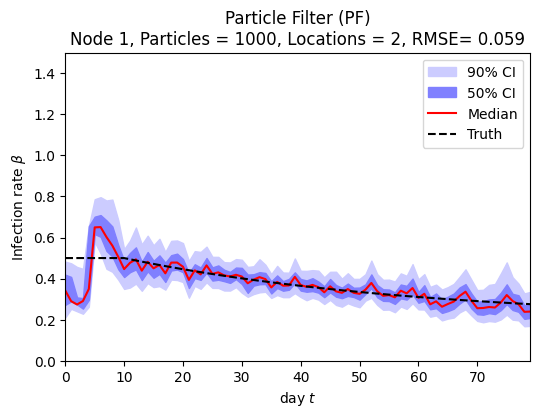

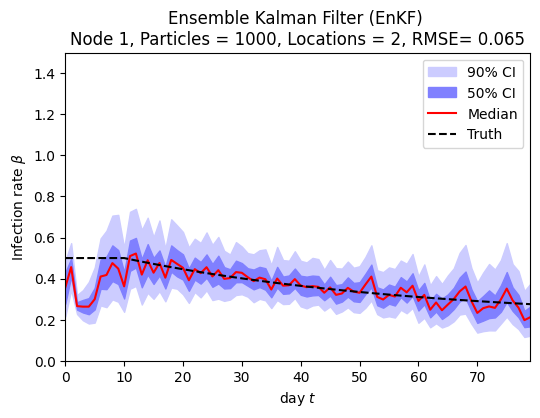

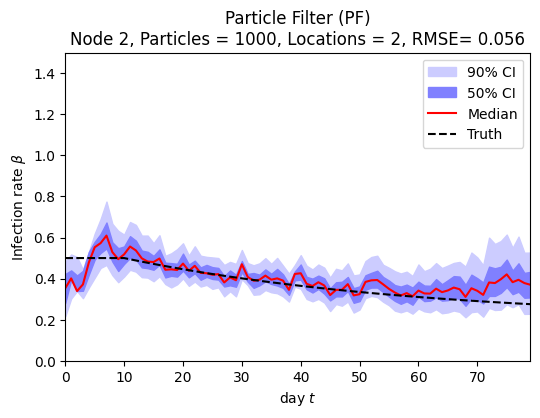

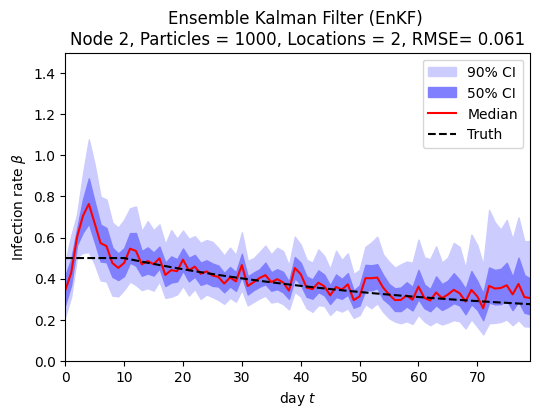

In [16]:
def plot_node_results(node_idx, save_mean, save_quantiles, beta_vector, model_name, algorithm_name):
    plt.figure(figsize=(6, 4))
    
    plt.fill_between(observation_times, save_quantiles[0, node_idx, :], save_quantiles[4, node_idx, :], color=[
                     0.8, 0.8, 1], label='90% CI')
    plt.fill_between(observation_times, save_quantiles[1, node_idx, :], save_quantiles[3, node_idx, :], color=[
                     0.5, 0.5, 1], label='50% CI')

    # Plot median and true beta
    plt.plot(observation_times,
             save_quantiles[2, node_idx, :], 'r-', label='Median')
    # plt.plot(observation_times,
            #  save_mean[node_idx, 3, :], ':', color='tab:orange', label='A specific particle')
    plt.plot(time_vector, beta_vector, 'k--', label='Truth')

    # Labels and title
    rmse = np.sqrt(np.mean((save_quantiles[2, node_idx, :] - beta_vector)**2))
    plt.xlabel('day $t$')
    plt.ylabel('Infection rate $\\beta$')
    plt.ylim([0, 1.5])
    plt.xlim([time_vector[0], time_vector[-1]])
    plt.title(f'{algorithm_name}\nNode {node_idx + 1}, Particles = {N}, Locations = {n_locations}, RMSE={rmse: .3f}')
    plt.legend()

    # Save the plot (optional)
    # plt.savefig(f'./figs/node_{node_idx + 1}_{model_name}.pdf', bbox_inches="tight")
    plt.show()

beta_vectors = []
for i in range(0, n_locations):
    # beta_vectors.append(save_mean_movement[i, 3, :])
    beta_vectors.append(beta[i, :])

particle_filter = "Particle Filter (PF)"
ensemble_kfilter = "Ensemble Kalman Filter (EnKF) "

# Generating plots for all nodes for both movement and non-movement models
for node_idx in range(n_locations):
    ...
    # Beta vector for movement and non-movement
    beta_vector_movement = beta_vectors[node_idx]
    beta_vector_non_movement = beta_vectors[node_idx]

    # Plot for Movement Model
    plot_node_results(node_idx, save_mean_movement_pf,
                      save_quantiles_movement_pf, beta_vector_movement, 'Movement Model', particle_filter)
    plot_node_results(node_idx, save_mean_movement_ekf,
                      save_quantiles_movement_ekf, beta_vector_movement, 'Movement Model', ensemble_kfilter)

    # Plot for Non-Movement Model
    # plot_node_results(node_idx, save_mean_no_movement, save_quantiles_no_movement,
    #                   beta_vector_non_movement, 'Non-Movement Model')